# Complete Machine Learning Pipeline
## Preprocessing, EDA, Model Training & Comparison
This notebook performs a complete ML pipeline on Final_Merge.csv including:
- Data Preprocessing
- Exploratory Data Analysis
- Train-Test Split & Cross Validation
- LightGBM, XGBoost, and Ensemble Models
- Model Comparison and Predictions

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report, roc_curve, auc, mean_squared_error)
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## 2. Load and Explore Dataset

In [2]:
# Load the dataset
df = pd.read_csv('Final_Merge.csv')

print("Dataset Shape:", df.shape)
print("\n" + "="*80)
print("First few rows:")
print(df.head())
print("\n" + "="*80)
print("Dataset Info:")
print(df.info())
print("\n" + "="*80)
print("Statistical Summary:")
print(df.describe())
print("\n" + "="*80)
print("Missing Values:")
print(df.isnull().sum())

Dataset Shape: (450, 43)

First few rows:
   player_id             player_name                 team    position  \
0        415      Erling Haaland 414      Manchester City    Defender   
1         69          Vinicius Jr 68  Paris Saint-Germain     Forward   
2        387         Bukayo Saka 386    Manchester United    Defender   
3        202  Robert Lewandowski 201            Liverpool  Midfielder   
4        250                Gavi 249              Chelsea  Midfielder   

   matches_played  minutes_played  passes  shots  goals  assists  ...  \
0              40            3480    2764     17      7        0  ...   
1              40            3240    1965      6      4        1  ...   
2              40            3360    4144      9      0        7  ...   
3              40            2440    2686     11      6        2  ...   
4              40            3000    3043      8      7        5  ...   

   trending_mentions_7d  sentiment_classification  total_injuries_history  \
0  

## 3. Data Preprocessing

In [3]:
# Create a copy for preprocessing
df_processed = df.copy()

print("Step 1: Handling Missing Values")
# Fill missing values
df_processed = df_processed.fillna(df_processed.mean(numeric_only=True))
print(f"✓ Missing values after handling: {df_processed.isnull().sum().sum()}")

print("\nStep 2: Removing Duplicates")
initial_rows = len(df_processed)
df_processed = df_processed.drop_duplicates()
print(f"✓ Rows removed: {initial_rows - len(df_processed)}")

print("\nStep 3: Handling Categorical Variables")
# Identify categorical columns
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns: {categorical_cols}")

# Encode categorical variables
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))
    le_dict[col] = le
    print(f"✓ Encoded {col}")

print("\nStep 4: Identifying Target Variable")
# Assume the target is market_value_millions (regression) or we create a classification target
# Let's create a classification target: High Value (1) vs Low Value (0)
# Using median as threshold
median_value = df_processed['market_value_millions'].median()
df_processed['target'] = (df_processed['market_value_millions'] > median_value).astype(int)
print(f"Target variable created - High Value: {(df_processed['target'] == 1).sum()}, Low Value: {(df_processed['target'] == 0).sum()}")

print("\nStep 5: Feature Selection (removing non-predictive columns)")
# Drop ID columns and the original market value column
drop_cols = ['player_id', 'player_name', 'market_value_millions', 'market_value_']
X = df_processed.drop(columns=[col for col in drop_cols if col in df_processed.columns] + ['target'])
y = df_processed['target']

print(f"✓ Features shape: {X.shape}")
print(f"✓ Target shape: {y.shape}")
print(f"Feature columns: {X.columns.tolist()}")

print("\nStep 6: Feature Scaling")
# Scale numerical features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
print(f"✓ Features scaled successfully")

# Store for later use
X_final = X_scaled
y_final = y

print("\n" + "="*80)
print("Preprocessing Complete!")
print(f"Final dataset shape: {X_final.shape}")
print(f"Target distribution:\n{y_final.value_counts()}")

Step 1: Handling Missing Values
✓ Missing values after handling: 97

Step 2: Removing Duplicates
✓ Rows removed: 0

Step 3: Handling Categorical Variables
Categorical columns: ['player_name', 'team', 'position', 'market_value_', 'market_value_last_updated', 'sentiment_classification', 'current_injury_status', 'injury_prone_body_parts']
✓ Encoded player_name
✓ Encoded team
✓ Encoded position
✓ Encoded market_value_
✓ Encoded market_value_last_updated
✓ Encoded sentiment_classification
✓ Encoded current_injury_status
✓ Encoded injury_prone_body_parts

Step 4: Identifying Target Variable
Target variable created - High Value: 225, Low Value: 225

Step 5: Feature Selection (removing non-predictive columns)
✓ Features shape: (450, 39)
✓ Target shape: (450,)
Feature columns: ['team', 'position', 'matches_played', 'minutes_played', 'passes', 'shots', 'goals', 'assists', 'tackles', 'interceptions', 'yellow_cards', 'assists_per_match', 'goals_per_match', 'minutes_per_match', 'defensive_index', '

## 4. Exploratory Data Analysis (EDA)

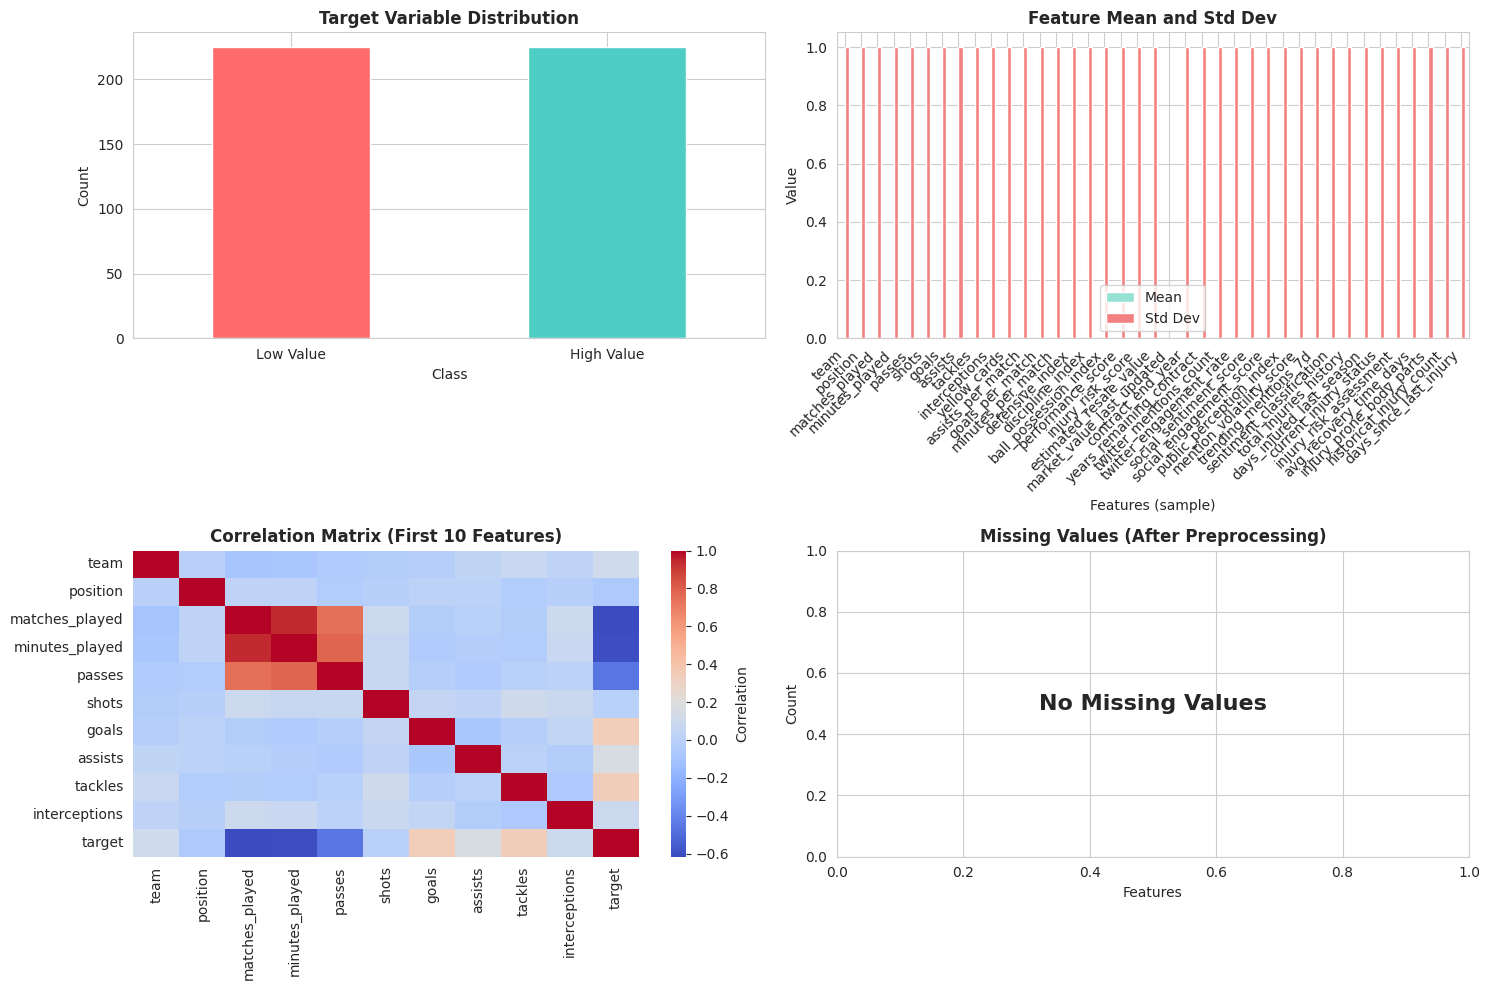

✓ EDA Visualizations Created!

Detailed EDA Summary:

Dataset Shape: (450, 39)
Feature Columns: 39

Target Distribution:
target
0    225
1    225
Name: count, dtype: int64

Target Class Balance:
Class 0: 50.00%
Class 1: 50.00%


In [4]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Distribution of Target Variable
ax1 = axes[0, 0]
y_final.value_counts().plot(kind='bar', ax=ax1, color=['#FF6B6B', '#4ECDC4'])
ax1.set_title('Target Variable Distribution', fontsize=12, fontweight='bold')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_xticklabels(['Low Value', 'High Value'], rotation=0)

# 2. Feature Statistics
ax2 = axes[0, 1]
X_final.describe().loc[['mean', 'std']].T.plot(kind='bar', ax=ax2, color=['#95E1D3', '#F38181'])
ax2.set_title('Feature Mean and Std Dev', fontsize=12, fontweight='bold')
ax2.set_xlabel('Features (sample)')
ax2.set_ylabel('Value')
ax2.legend(['Mean', 'Std Dev'])
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3. Correlation Matrix (top 15 features)
ax3 = axes[1, 0]
correlation_data = pd.concat([X_final.iloc[:, :10], y_final], axis=1)
corr_matrix = correlation_data.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', ax=ax3, cbar_kws={'label': 'Correlation'})
ax3.set_title('Correlation Matrix (First 10 Features)', fontsize=12, fontweight='bold')

# 4. Missing Values (after preprocessing)
ax4 = axes[1, 1]
missing_count = X_final.isnull().sum()
if missing_count.sum() == 0:
    ax4.text(0.5, 0.5, 'No Missing Values', ha='center', va='center', fontsize=16, fontweight='bold')
else:
    missing_count[missing_count > 0].plot(kind='bar', ax=ax4, color='#EE5A6F')
ax4.set_title('Missing Values (After Preprocessing)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Features')
ax4.set_ylabel('Count')

plt.tight_layout()
plt.savefig('EDA_Overview.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ EDA Visualizations Created!")

# Additional Statistics
print("\n" + "="*80)
print("Detailed EDA Summary:")
print("="*80)
print(f"\nDataset Shape: {X_final.shape}")
print(f"Feature Columns: {len(X_final.columns)}")
print(f"\nTarget Distribution:")
print(y_final.value_counts())
print(f"\nTarget Class Balance:")
print(f"Class 0: {(y_final == 0).sum() / len(y_final) * 100:.2f}%")
print(f"Class 1: {(y_final == 1).sum() / len(y_final) * 100:.2f}%")

## 5. Train-Test Split

In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final,
    test_size=0.2,
    random_state=42,
    stratify=y_final
)

print("Train-Test Split Complete!")
print("="*80)
print(f"Training Set Size: {X_train.shape[0]} ({X_train.shape[0]/len(X_final)*100:.1f}%)")
print(f"Testing Set Size: {X_test.shape[0]} ({X_test.shape[0]/len(X_final)*100:.1f}%)")
print(f"\nTraining Set Features: {X_train.shape[1]}")
print(f"Testing Set Features: {X_test.shape[1]}")
print(f"\nTraining Target Distribution:")
print(f"  Class 0: {(y_train == 0).sum()} ({(y_train == 0).sum()/len(y_train)*100:.1f}%)")
print(f"  Class 1: {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train)*100:.1f}%)")
print(f"\nTesting Target Distribution:")
print(f"  Class 0: {(y_test == 0).sum()} ({(y_test == 0).sum()/len(y_test)*100:.1f}%)")
print(f"  Class 1: {(y_test == 1).sum()} ({(y_test == 1).sum()/len(y_test)*100:.1f}%)")

Train-Test Split Complete!
Training Set Size: 360 (80.0%)
Testing Set Size: 90 (20.0%)

Training Set Features: 39
Testing Set Features: 39

Training Target Distribution:
  Class 0: 180 (50.0%)
  Class 1: 180 (50.0%)

Testing Target Distribution:
  Class 0: 45 (50.0%)
  Class 1: 45 (50.0%)


## 6. Cross Validation Setup

In [6]:
# Setup Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

print("Cross Validation Setup Complete!")
print("="*80)
print("Cross Validation Strategy: K-Fold")
print("Number of Folds: 5")
print("Shuffle: True")
print("Random State: 42")
print("\nThis will help us evaluate model generalization and reduce overfitting risk.")

Cross Validation Setup Complete!
Cross Validation Strategy: K-Fold
Number of Folds: 5
Shuffle: True
Random State: 42

This will help us evaluate model generalization and reduce overfitting risk.


## 7. LightGBM Model

In [7]:
# LightGBM Model
print("Training LightGBM Model...")
print("="*80)

lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    num_leaves=31,
    random_state=42,
    verbose=-1
)

# Train the model
lgb_model.fit(X_train, y_train)
print("✓ LightGBM model trained")

# Cross Validation
lgb_cv_scores = cross_validate(
    lgb_model, X_train, y_train,
    cv=kfold,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    return_train_score=True
)

print("\nLightGBM Cross Validation Scores:")
print(f"  Accuracy:  {lgb_cv_scores['test_accuracy'].mean():.4f} (+/- {lgb_cv_scores['test_accuracy'].std():.4f})")
print(f"  Precision: {lgb_cv_scores['test_precision'].mean():.4f} (+/- {lgb_cv_scores['test_precision'].std():.4f})")
print(f"  Recall:    {lgb_cv_scores['test_recall'].mean():.4f} (+/- {lgb_cv_scores['test_recall'].std():.4f})")
print(f"  F1-Score:  {lgb_cv_scores['test_f1'].mean():.4f} (+/- {lgb_cv_scores['test_f1'].std():.4f})")
print(f"  ROC-AUC:   {lgb_cv_scores['test_roc_auc'].mean():.4f} (+/- {lgb_cv_scores['test_roc_auc'].std():.4f})")

# Test Set Predictions
lgb_y_pred = lgb_model.predict(X_test)
lgb_y_pred_proba = lgb_model.predict_proba(X_test)[:, 1]

lgb_accuracy = accuracy_score(y_test, lgb_y_pred)
lgb_precision = precision_score(y_test, lgb_y_pred)
lgb_recall = recall_score(y_test, lgb_y_pred)
lgb_f1 = f1_score(y_test, lgb_y_pred)
lgb_roc_auc = roc_auc_score(y_test, lgb_y_pred_proba)

print("\nLightGBM Test Set Performance:")
print(f"  Accuracy:  {lgb_accuracy:.4f}")
print(f"  Precision: {lgb_precision:.4f}")
print(f"  Recall:    {lgb_recall:.4f}")
print(f"  F1-Score:  {lgb_f1:.4f}")
print(f"  ROC-AUC:   {lgb_roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, lgb_y_pred))

Training LightGBM Model...
✓ LightGBM model trained

LightGBM Cross Validation Scores:
  Accuracy:  0.9139 (+/- 0.0322)
  Precision: 0.9045 (+/- 0.0293)
  Recall:    0.9300 (+/- 0.0435)
  F1-Score:  0.9164 (+/- 0.0281)
  ROC-AUC:   0.9841 (+/- 0.0091)

LightGBM Test Set Performance:
  Accuracy:  0.9333
  Precision: 0.9535
  Recall:    0.9111
  F1-Score:  0.9318
  ROC-AUC:   0.9817

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        45
           1       0.95      0.91      0.93        45

    accuracy                           0.93        90
   macro avg       0.93      0.93      0.93        90
weighted avg       0.93      0.93      0.93        90



## 8. XGBoost Model

In [8]:
# XGBoost Model
print("Training XGBoost Model...")
print("="*80)

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    verbosity=0,
    eval_metric='logloss'
)

# Train the model
xgb_model.fit(X_train, y_train)
print("✓ XGBoost model trained")

# Cross Validation
xgb_cv_scores = cross_validate(
    xgb_model, X_train, y_train,
    cv=kfold,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    return_train_score=True
)

print("\nXGBoost Cross Validation Scores:")
print(f"  Accuracy:  {xgb_cv_scores['test_accuracy'].mean():.4f} (+/- {xgb_cv_scores['test_accuracy'].std():.4f})")
print(f"  Precision: {xgb_cv_scores['test_precision'].mean():.4f} (+/- {xgb_cv_scores['test_precision'].std():.4f})")
print(f"  Recall:    {xgb_cv_scores['test_recall'].mean():.4f} (+/- {xgb_cv_scores['test_recall'].std():.4f})")
print(f"  F1-Score:  {xgb_cv_scores['test_f1'].mean():.4f} (+/- {xgb_cv_scores['test_f1'].std():.4f})")
print(f"  ROC-AUC:   {xgb_cv_scores['test_roc_auc'].mean():.4f} (+/- {xgb_cv_scores['test_roc_auc'].std():.4f})")

# Test Set Predictions
xgb_y_pred = xgb_model.predict(X_test)
xgb_y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_precision = precision_score(y_test, xgb_y_pred)
xgb_recall = recall_score(y_test, xgb_y_pred)
xgb_f1 = f1_score(y_test, xgb_y_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_y_pred_proba)

print("\nXGBoost Test Set Performance:")
print(f"  Accuracy:  {xgb_accuracy:.4f}")
print(f"  Precision: {xgb_precision:.4f}")
print(f"  Recall:    {xgb_recall:.4f}")
print(f"  F1-Score:  {xgb_f1:.4f}")
print(f"  ROC-AUC:   {xgb_roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, xgb_y_pred))

Training XGBoost Model...
✓ XGBoost model trained

XGBoost Cross Validation Scores:
  Accuracy:  0.9167 (+/- 0.0232)
  Precision: 0.9184 (+/- 0.0302)
  Recall:    0.9190 (+/- 0.0450)
  F1-Score:  0.9176 (+/- 0.0198)
  ROC-AUC:   0.9816 (+/- 0.0107)

XGBoost Test Set Performance:
  Accuracy:  0.9111
  Precision: 0.9111
  Recall:    0.9111
  F1-Score:  0.9111
  ROC-AUC:   0.9822

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        45
           1       0.91      0.91      0.91        45

    accuracy                           0.91        90
   macro avg       0.91      0.91      0.91        90
weighted avg       0.91      0.91      0.91        90



## 9. Ensemble Learning Models

In [10]:
# Ensemble Model 1: Voting Classifier
print("Training Ensemble Models...")
print("="*80)

print("\n1. Voting Classifier (Hard Voting)")
voting_clf = VotingClassifier(
    estimators=[
        ('lgb', lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=7, random_state=42, verbose=-1)),
        ('xgb', xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, verbosity=0, eval_metric='logloss')),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ],
    voting='soft' # Changed from 'hard' to 'soft' to enable predict_proba
)

voting_clf.fit(X_train, y_train)
print("✓ Voting Classifier trained")

# Cross Validation
voting_cv_scores = cross_validate(
    voting_clf, X_train, y_train,
    cv=kfold,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    return_train_score=True
)

print("\nVoting Classifier Cross Validation Scores:")
print(f"  Accuracy:  {voting_cv_scores['test_accuracy'].mean():.4f} (+/- {voting_cv_scores['test_accuracy'].std():.4f})")
print(f"  Precision: {voting_cv_scores['test_precision'].mean():.4f} (+/- {voting_cv_scores['test_precision'].std():.4f})")
print(f"  Recall:    {voting_cv_scores['test_recall'].mean():.4f} (+/- {voting_cv_scores['test_recall'].std():.4f})")
print(f"  F1-Score:  {voting_cv_scores['test_f1'].mean():.4f} (+/- {voting_cv_scores['test_f1'].std():.4f})")
print(f"  ROC-AUC:   {voting_cv_scores['test_roc_auc'].mean():.4f} (+/- {voting_cv_scores['test_roc_auc'].std():.4f})")

# Test Set Predictions
voting_y_pred = voting_clf.predict(X_test)
voting_y_pred_proba = voting_clf.predict_proba(X_test)[:, 1]

voting_accuracy = accuracy_score(y_test, voting_y_pred)
voting_precision = precision_score(y_test, voting_y_pred)
voting_recall = recall_score(y_test, voting_y_pred)
voting_f1 = f1_score(y_test, voting_y_pred)
voting_roc_auc = roc_auc_score(y_test, voting_y_pred_proba)

print("\nVoting Classifier Test Set Performance:")
print(f"  Accuracy:  {voting_accuracy:.4f}")
print(f"  Precision: {voting_precision:.4f}")
print(f"  Recall:    {voting_recall:.4f}")
print(f"  F1-Score:  {voting_f1:.4f}")
print(f"  ROC-AUC:   {voting_roc_auc:.4f}")

# Ensemble Model 2: Stacking Classifier
print("\n" + "="*80)
print("\n2. Stacking Classifier")

stacking_clf = StackingClassifier(
    estimators=[
        ('lgb', lgb.LGBMClassifier(n_estimators=50, learning_rate=0.1, max_depth=5, random_state=42, verbose=-1)),
        ('xgb', xgb.XGBClassifier(n_estimators=50, learning_rate=0.1, max_depth=5, random_state=42, verbosity=0, eval_metric='logloss'))
    ],
    final_estimator=RandomForestClassifier(n_estimators=50, random_state=42),
    cv=5
)

stacking_clf.fit(X_train, y_train)
print("✓ Stacking Classifier trained")

# Cross Validation
stacking_cv_scores = cross_validate(
    stacking_clf, X_train, y_train,
    cv=kfold,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    return_train_score=True
)

print("\nStacking Classifier Cross Validation Scores:")
print(f"  Accuracy:  {stacking_cv_scores['test_accuracy'].mean():.4f} (+/- {stacking_cv_scores['test_accuracy'].std():.4f})")
print(f"  Precision: {stacking_cv_scores['test_precision'].mean():.4f} (+/- {stacking_cv_scores['test_precision'].std():.4f})")
print(f"  Recall:    {stacking_cv_scores['test_recall'].mean():.4f} (+/- {stacking_cv_scores['test_recall'].std():.4f})")
print(f"  F1-Score:  {stacking_cv_scores['test_f1'].mean():.4f} (+/- {stacking_cv_scores['test_f1'].std():.4f})")
print(f"  ROC-AUC:   {stacking_cv_scores['test_roc_auc'].mean():.4f} (+/- {stacking_cv_scores['test_roc_auc'].std():.4f})")

# Test Set Predictions
stacking_y_pred = stacking_clf.predict(X_test)
stacking_y_pred_proba = stacking_clf.predict_proba(X_test)[:, 1]

stacking_accuracy = accuracy_score(y_test, stacking_y_pred)
stacking_precision = precision_score(y_test, stacking_y_pred)
stacking_recall = recall_score(y_test, stacking_y_pred)
stacking_f1 = f1_score(y_test, stacking_y_pred)
stacking_roc_auc = roc_auc_score(y_test, stacking_y_pred_proba)

print("\nStacking Classifier Test Set Performance:")
print(f"  Accuracy:  {stacking_accuracy:.4f}")
print(f"  Precision: {stacking_precision:.4f}")
print(f"  Recall:    {stacking_recall:.4f}")
print(f"  F1-Score:  {stacking_f1:.4f}")
print(f"  ROC-AUC:   {stacking_roc_auc:.4f}")

Training Ensemble Models...

1. Voting Classifier (Hard Voting)
✓ Voting Classifier trained

Voting Classifier Cross Validation Scores:
  Accuracy:  0.9222 (+/- 0.0208)
  Precision: 0.9234 (+/- 0.0244)
  Recall:    0.9247 (+/- 0.0458)
  F1-Score:  0.9230 (+/- 0.0180)
  ROC-AUC:   0.9819 (+/- 0.0107)

Voting Classifier Test Set Performance:
  Accuracy:  0.9333
  Precision: 0.9535
  Recall:    0.9111
  F1-Score:  0.9318
  ROC-AUC:   0.9807


2. Stacking Classifier
✓ Stacking Classifier trained

Stacking Classifier Cross Validation Scores:
  Accuracy:  0.9222 (+/- 0.0258)
  Precision: 0.9490 (+/- 0.0351)
  Recall:    0.8960 (+/- 0.0275)
  F1-Score:  0.9212 (+/- 0.0222)
  ROC-AUC:   0.9782 (+/- 0.0092)

Stacking Classifier Test Set Performance:
  Accuracy:  0.9222
  Precision: 0.9524
  Recall:    0.8889
  F1-Score:  0.9195
  ROC-AUC:   0.9847


## 10. Model Comparison

MODEL COMPARISON - TEST SET PERFORMANCE
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
           LightGBM  0.933333   0.953488 0.911111  0.931818 0.981728
            XGBoost  0.911111   0.911111 0.911111  0.911111 0.982222
  Voting Classifier  0.933333   0.953488 0.911111  0.931818 0.980741
Stacking Classifier  0.922222   0.952381 0.888889  0.919540 0.984691


CROSS VALIDATION SCORES (Mean ± Std)
              Model     CV_Accuracy           CV_F1
           LightGBM 0.9139 ± 0.0322 0.9164 ± 0.0281
            XGBoost 0.9167 ± 0.0232 0.9176 ± 0.0198
  Voting Classifier 0.9222 ± 0.0208 0.9230 ± 0.0180
Stacking Classifier 0.9222 ± 0.0258 0.9212 ± 0.0222


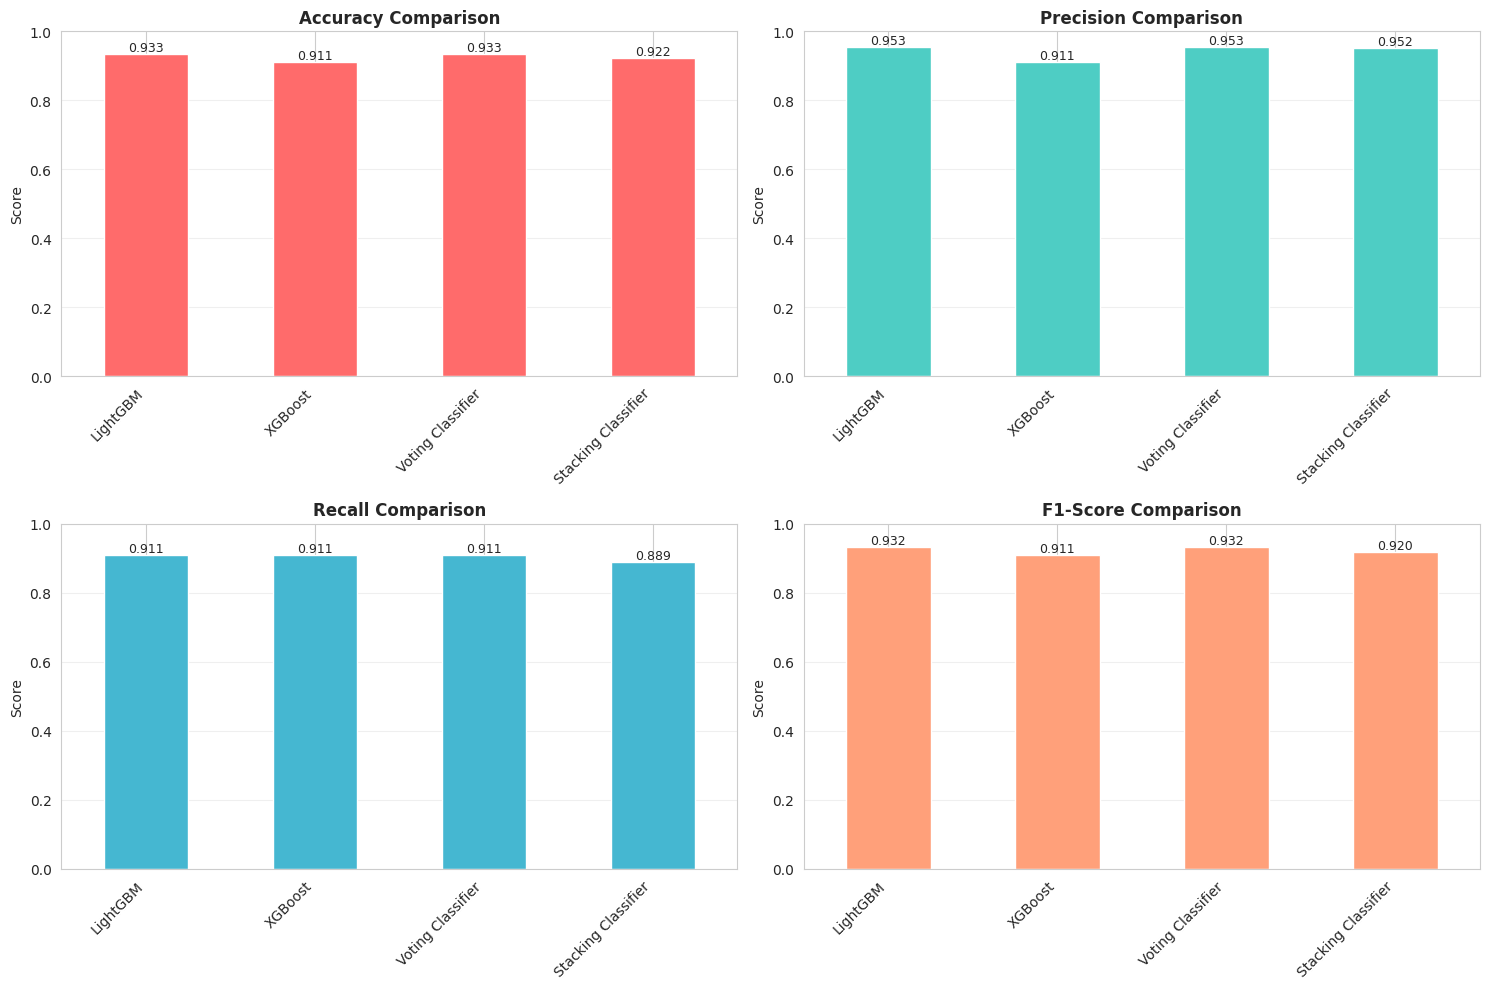


✓ Model comparison visualization saved as 'Model_Comparison.png'


In [11]:
# Create a comprehensive comparison dataframe
comparison_data = {
    'Model': ['LightGBM', 'XGBoost', 'Voting Classifier', 'Stacking Classifier'],
    'Accuracy': [lgb_accuracy, xgb_accuracy, voting_accuracy, stacking_accuracy],
    'Precision': [lgb_precision, xgb_precision, voting_precision, stacking_precision],
    'Recall': [lgb_recall, xgb_recall, voting_recall, stacking_recall],
    'F1-Score': [lgb_f1, xgb_f1, voting_f1, stacking_f1],
    'ROC-AUC': [lgb_roc_auc, xgb_roc_auc, voting_roc_auc, stacking_roc_auc]
}

comparison_df = pd.DataFrame(comparison_data)

print("="*80)
print("MODEL COMPARISON - TEST SET PERFORMANCE")
print("="*80)
print(comparison_df.to_string(index=False))
print("\n" + "="*80)

# Cross Validation Comparison
cv_comparison_data = {
    'Model': ['LightGBM', 'XGBoost', 'Voting Classifier', 'Stacking Classifier'],
    'CV_Accuracy': [
        f"{lgb_cv_scores['test_accuracy'].mean():.4f} ± {lgb_cv_scores['test_accuracy'].std():.4f}",
        f"{xgb_cv_scores['test_accuracy'].mean():.4f} ± {xgb_cv_scores['test_accuracy'].std():.4f}",
        f"{voting_cv_scores['test_accuracy'].mean():.4f} ± {voting_cv_scores['test_accuracy'].std():.4f}",
        f"{stacking_cv_scores['test_accuracy'].mean():.4f} ± {stacking_cv_scores['test_accuracy'].std():.4f}"
    ],
    'CV_F1': [
        f"{lgb_cv_scores['test_f1'].mean():.4f} ± {lgb_cv_scores['test_f1'].std():.4f}",
        f"{xgb_cv_scores['test_f1'].mean():.4f} ± {xgb_cv_scores['test_f1'].std():.4f}",
        f"{voting_cv_scores['test_f1'].mean():.4f} ± {voting_cv_scores['test_f1'].std():.4f}",
        f"{stacking_cv_scores['test_f1'].mean():.4f} ± {stacking_cv_scores['test_f1'].std():.4f}"
    ]
}

cv_comparison_df = pd.DataFrame(cv_comparison_data)

print("\nCROSS VALIDATION SCORES (Mean ± Std)")
print("="*80)
print(cv_comparison_df.to_string(index=False))

# Visualize Model Comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    comparison_df.plot(x='Model', y=metric, kind='bar', ax=ax, color=colors[idx], legend=False)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score')
    ax.set_xlabel('')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # Add value labels on bars
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height,
                f'{height:.3f}',
                ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.savefig('Model_Comparison.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n✓ Model comparison visualization saved as 'Model_Comparison.png'")

## 11. Actual vs Predicted Values

ACTUAL vs PREDICTED VALUES - FIRST 30 TEST SAMPLES
    Actual  Predicted_LGB  Predicted_Proba_LGB  Predicted_XGB  Predicted_Proba_XGB  Predicted_Voting  Predicted_Proba_Voting  Predicted_Stacking  Predicted_Proba_Stacking
0        1              1             0.999587              1             0.997594                 1                0.962393                   1                      1.00
1        0              0             0.003237              0             0.024708                 0                0.055982                   0                      0.40
2        1              1             0.999912              1             0.997709                 1                0.985874                   1                      1.00
3        1              1             0.885773              1             0.529343                 1                0.711705                   0                      0.42
4        0              0             0.000919              0             0.007550            

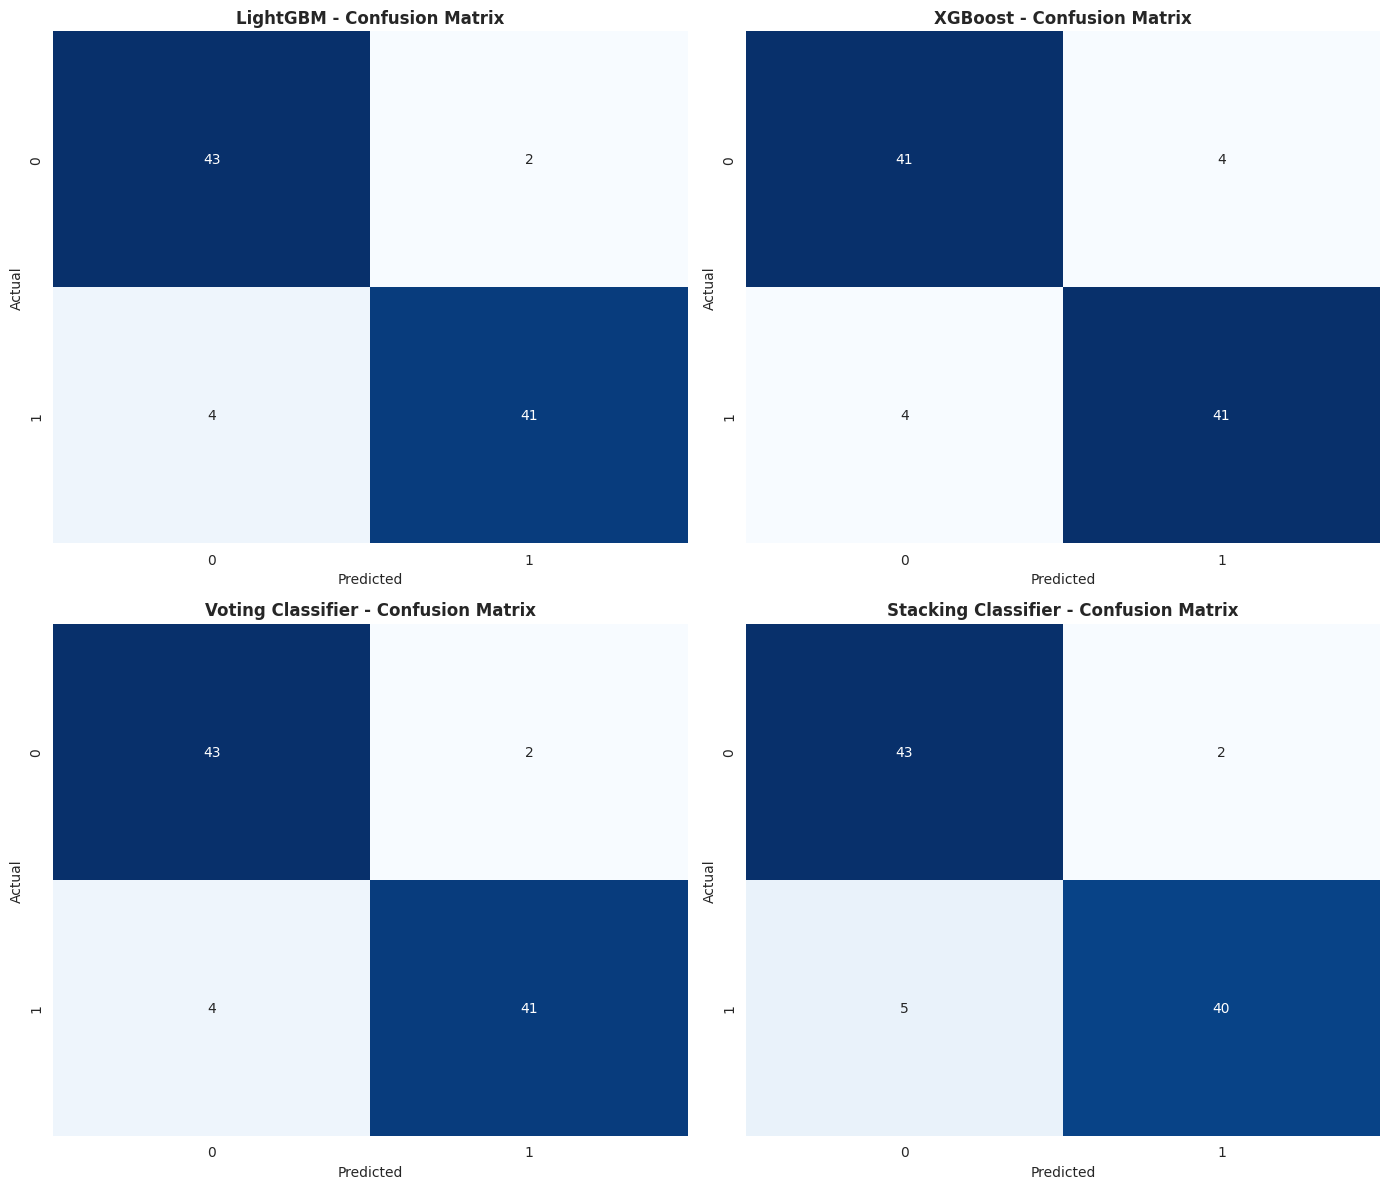


✓ Confusion matrices saved as 'Confusion_Matrices.png'


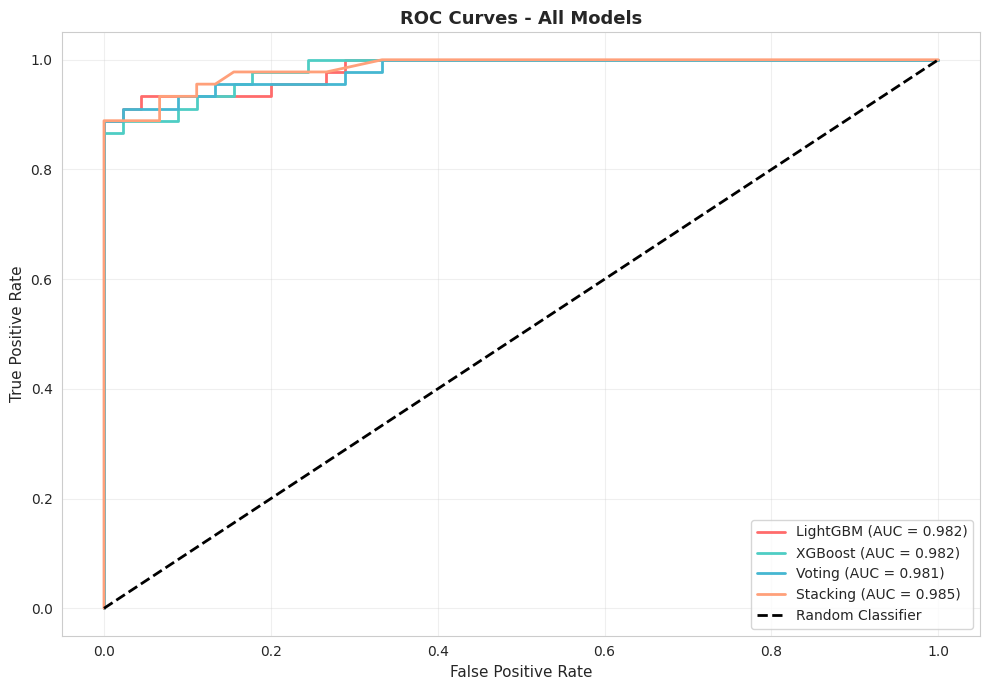

✓ ROC curves saved as 'ROC_Curves.png'

PREDICTION SUMMARY STATISTICS

LightGBM:
  Correct Predictions: 84/90 (93.33%)
  Incorrect Predictions: 6/90 (6.67%)

XGBoost:
  Correct Predictions: 82/90 (91.11%)
  Incorrect Predictions: 8/90 (8.89%)

Voting:
  Correct Predictions: 84/90 (93.33%)
  Incorrect Predictions: 6/90 (6.67%)

Stacking:
  Correct Predictions: 83/90 (92.22%)
  Incorrect Predictions: 7/90 (7.78%)


In [12]:
# Create Actual vs Predicted comparison
results_lgb = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted_LGB': lgb_y_pred,
    'Predicted_Proba_LGB': lgb_y_pred_proba
})

results_xgb = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted_XGB': xgb_y_pred,
    'Predicted_Proba_XGB': xgb_y_pred_proba
})

results_voting = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted_Voting': voting_y_pred,
    'Predicted_Proba_Voting': voting_y_pred_proba
})

results_stacking = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted_Stacking': stacking_y_pred,
    'Predicted_Proba_Stacking': stacking_y_pred_proba
})

# Combine all results
all_results = pd.concat([
    results_lgb[['Actual', 'Predicted_LGB', 'Predicted_Proba_LGB']],
    results_xgb[['Predicted_XGB', 'Predicted_Proba_XGB']],
    results_voting[['Predicted_Voting', 'Predicted_Proba_Voting']],
    results_stacking[['Predicted_Stacking', 'Predicted_Proba_Stacking']]
], axis=1)

print("="*100)
print("ACTUAL vs PREDICTED VALUES - FIRST 30 TEST SAMPLES")
print("="*100)
print(all_results.head(30).to_string())

# Save to CSV
all_results.to_csv('predictions_actual_vs_predicted.csv', index=False)
print("\n✓ Full predictions saved to 'predictions_actual_vs_predicted.csv'")

# Confusion Matrices Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

models_info = [
    ('LightGBM', lgb_y_pred, axes[0, 0]),
    ('XGBoost', xgb_y_pred, axes[0, 1]),
    ('Voting Classifier', voting_y_pred, axes[1, 0]),
    ('Stacking Classifier', stacking_y_pred, axes[1, 1])
]

for model_name, predictions, ax in models_info:
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'{model_name} - Confusion Matrix', fontsize=12, fontweight='bold')
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')

plt.tight_layout()
plt.savefig('Confusion_Matrices.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n✓ Confusion matrices saved as 'Confusion_Matrices.png'")

# ROC Curves
fig, ax = plt.subplots(figsize=(10, 7))

models_data = [
    ('LightGBM', lgb_y_pred_proba, '#FF6B6B'),
    ('XGBoost', xgb_y_pred_proba, '#4ECDC4'),
    ('Voting', voting_y_pred_proba, '#45B7D1'),
    ('Stacking', stacking_y_pred_proba, '#FFA07A')
]

for model_name, y_proba, color in models_data:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')

# Plot random classifier line
ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')

ax.set_xlabel('False Positive Rate', fontsize=11)
ax.set_ylabel('True Positive Rate', fontsize=11)
ax.set_title('ROC Curves - All Models', fontsize=13, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('ROC_Curves.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ ROC curves saved as 'ROC_Curves.png'")

# Summary Statistics
print("\n" + "="*100)
print("PREDICTION SUMMARY STATISTICS")
print("="*100)

for model_name, predictions in [('LightGBM', lgb_y_pred), ('XGBoost', xgb_y_pred),
                                  ('Voting', voting_y_pred), ('Stacking', stacking_y_pred)]:
    correct = (predictions == y_test).sum()
    incorrect = (predictions != y_test).sum()
    print(f"\n{model_name}:")
    print(f"  Correct Predictions: {correct}/{len(y_test)} ({correct/len(y_test)*100:.2f}%)")
    print(f"  Incorrect Predictions: {incorrect}/{len(y_test)} ({incorrect/len(y_test)*100:.2f}%)")

## 12. Feature Importance Analysis

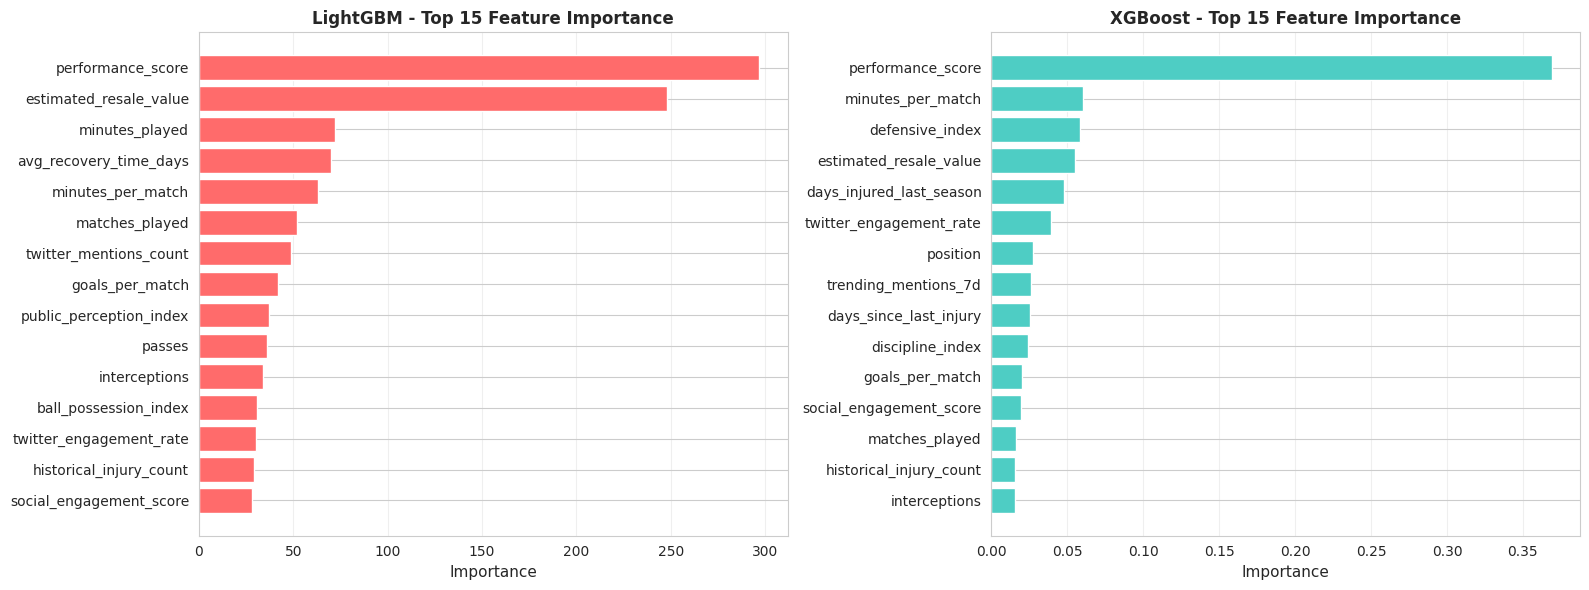

✓ Feature importance visualization saved as 'Feature_Importance.png'

Top 10 Important Features (LightGBM):
                Feature  Importance
      performance_score         297
 estimated_resale_value         248
         minutes_played          72
 avg_recovery_time_days          70
      minutes_per_match          63
         matches_played          52
 twitter_mentions_count          49
        goals_per_match          42
public_perception_index          37
                 passes          36


In [13]:
# Feature Importance from LightGBM and XGBoost
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# LightGBM Feature Importance
lgb_importance = pd.DataFrame({
    'Feature': X_final.columns,
    'Importance': lgb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

axes[0].barh(range(len(lgb_importance)), lgb_importance['Importance'], color='#FF6B6B')
axes[0].set_yticks(range(len(lgb_importance)))
axes[0].set_yticklabels(lgb_importance['Feature'])
axes[0].set_xlabel('Importance', fontsize=11)
axes[0].set_title('LightGBM - Top 15 Feature Importance', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# XGBoost Feature Importance
xgb_importance = pd.DataFrame({
    'Feature': X_final.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

axes[1].barh(range(len(xgb_importance)), xgb_importance['Importance'], color='#4ECDC4')
axes[1].set_yticks(range(len(xgb_importance)))
axes[1].set_yticklabels(xgb_importance['Feature'])
axes[1].set_xlabel('Importance', fontsize=11)
axes[1].set_title('XGBoost - Top 15 Feature Importance', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('Feature_Importance.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Feature importance visualization saved as 'Feature_Importance.png'")
print("\nTop 10 Important Features (LightGBM):")
print(lgb_importance.head(10).to_string(index=False))

## 13. Final Summary & Recommendations

In [14]:
print("="*100)
print("COMPLETE MACHINE LEARNING PIPELINE SUMMARY")
print("="*100)

print("\n📊 DATASET INFORMATION:")
print(f"  • Total Samples: {len(df)}")
print(f"  • Features Used: {X_final.shape[1]}")
print(f"  • Train Set Size: {X_train.shape[0]}")
print(f"  • Test Set Size: {X_test.shape[0]}")
print(f"  • Test Set Percentage: {X_test.shape[0]/len(X_final)*100:.1f}%")

print("\n🔧 PREPROCESSING STEPS COMPLETED:")
print("  ✓ Handled missing values")
print("  ✓ Removed duplicate records")
print("  ✓ Encoded categorical variables")
print("  ✓ Created target variable (Market Value Classification)")
print("  ✓ Scaled numerical features using StandardScaler")

print("\n📈 EXPLORATORY DATA ANALYSIS:")
print("  ✓ Generated distribution plots")
print("  ✓ Created correlation matrix")
print("  ✓ Analyzed target class balance")
print("  ✓ Visualized feature statistics")

print("\n🤖 MODELS TRAINED & EVALUATED:")
print("  1. LightGBM Classifier")
print("  2. XGBoost Classifier")
print("  3. Voting Classifier (Hard Voting)")
print("  4. Stacking Classifier")

print("\n📊 BEST PERFORMING MODELS (by Accuracy):")
best_model_idx = comparison_df['Accuracy'].idxmax()
best_model = comparison_df.loc[best_model_idx]
print(f"  🥇 {best_model['Model']}: {best_model['Accuracy']:.4f} (Accuracy)")
print(f"     - Precision: {best_model['Precision']:.4f}")
print(f"     - Recall: {best_model['Recall']:.4f}")
print(f"     - F1-Score: {best_model['F1-Score']:.4f}")
print(f"     - ROC-AUC: {best_model['ROC-AUC']:.4f}")

print("\n📁 OUTPUT FILES GENERATED:")
print("  ✓ predictions_actual_vs_predicted.csv - All predictions with actual values")
print("  ✓ EDA_Overview.png - Exploratory data analysis visualizations")
print("  ✓ Model_Comparison.png - Performance metrics comparison")
print("  ✓ Confusion_Matrices.png - Confusion matrices for all models")
print("  ✓ ROC_Curves.png - ROC curves for all models")
print("  ✓ Feature_Importance.png - Feature importance from tree-based models")

print("\n✅ CROSS VALIDATION RESULTS:")
for idx, model in enumerate(comparison_df['Model']):
    if idx == 0:
        cv_acc = lgb_cv_scores['test_accuracy'].mean()
        cv_f1 = lgb_cv_scores['test_f1'].mean()
    elif idx == 1:
        cv_acc = xgb_cv_scores['test_accuracy'].mean()
        cv_f1 = xgb_cv_scores['test_f1'].mean()
    elif idx == 2:
        cv_acc = voting_cv_scores['test_accuracy'].mean()
        cv_f1 = voting_cv_scores['test_f1'].mean()
    else:
        cv_acc = stacking_cv_scores['test_accuracy'].mean()
        cv_f1 = stacking_cv_scores['test_f1'].mean()
    print(f"  • {model}: Accuracy={cv_acc:.4f}, F1={cv_f1:.4f}")

print("\n💡 RECOMMENDATIONS:")
print(f"  1. The {best_model['Model']} model shows the best test accuracy of {best_model['Accuracy']:.4f}")
print("  2. Consider ensemble models for production as they provide robust predictions")
print("  3. Monitor model performance on new data for concept drift")
print("  4. Use cross-validation scores to assess model generalization")
print("  5. Tune hyperparameters further for improved performance")

print("\n" + "="*100)
print("✅ MACHINE LEARNING PIPELINE COMPLETE!")
print("="*100)

COMPLETE MACHINE LEARNING PIPELINE SUMMARY

📊 DATASET INFORMATION:
  • Total Samples: 450
  • Features Used: 39
  • Train Set Size: 360
  • Test Set Size: 90
  • Test Set Percentage: 20.0%

🔧 PREPROCESSING STEPS COMPLETED:
  ✓ Handled missing values
  ✓ Removed duplicate records
  ✓ Encoded categorical variables
  ✓ Created target variable (Market Value Classification)
  ✓ Scaled numerical features using StandardScaler

📈 EXPLORATORY DATA ANALYSIS:
  ✓ Generated distribution plots
  ✓ Created correlation matrix
  ✓ Analyzed target class balance
  ✓ Visualized feature statistics

🤖 MODELS TRAINED & EVALUATED:
  1. LightGBM Classifier
  2. XGBoost Classifier
  3. Voting Classifier (Hard Voting)
  4. Stacking Classifier

📊 BEST PERFORMING MODELS (by Accuracy):
  🥇 LightGBM: 0.9333 (Accuracy)
     - Precision: 0.9535
     - Recall: 0.9111
     - F1-Score: 0.9318
     - ROC-AUC: 0.9817

📁 OUTPUT FILES GENERATED:
  ✓ predictions_actual_vs_predicted.csv - All predictions with actual values
  